# XArray example of _load_by_step_ _accessor_ evaluation

In this notebook we use and compare the _accessor_ _**load_by_step()**_ with the _xarray_ built in function _**load()**_ when accessing data through a remote server. To do so, we apply this function in a [HYCOM](https://www.hycom.org/) model output.

## **Example 1**: **_load_by_step_()** by splitting Spatio-Temporal maps in time

In [1]:
from __future__ import annotations

import time

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
def convert_to_360(lon):
    return float(np.remainder(lon + 360, 360))

In [4]:
###File Location and Domain Definition
url = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
ds = xr.open_dataset(url, drop_variables="tau")

### Domain Specification
lonmin = -54
lonmax = -31
latmin = -36
latmax = 7
selvar = "water_u"

da = ds[selvar].sel(
    lon=slice(convert_to_360(lonmin), convert_to_360(lonmax)), lat=slice(latmin, latmax)
)

In [5]:
unit = 1e9
print(f"The present dataset is about {np.round(da.nbytes/unit)}GB in size")
print(
    f"The amount of data present in a single level is about {np.round(da.sel(depth=0).nbytes/unit)}GB"
)

The present dataset is about 831.0GB in size
The amount of data present in a single level is about 21.0GB


In [6]:
da2 = da.sel(depth=0, time=slice("2024-01-01", "2024-01-10"))
da2

<xarray.DataArray 'water_u' (time: 80, lat: 1076, lon: 288)> Size: 99MB
[24791040 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 9kB -36.0 -35.96 -35.92 -35.88 ... 6.88 6.92 6.96 7.0
  * lon      (lon) float64 2kB 306.0 306.1 306.2 306.2 ... 328.8 328.9 329.0
  * time     (time) datetime64[ns] 640B 2024-01-01 ... 2024-01-10T21:00:00
    depth    float64 8B 0.0
Attributes:
    _CoordinateAxes:  time depth lat lon 
    long_name:        Eastward Water Velocity
    standard_name:    eastward_sea_water_velocity
    units:            m/s
    NAVO_code:        17

In [7]:
da2._in_memory

False

The **_load_by_step()_** accessor allows the user to define which dimension the data should be splitted in. In this first example, we will split the _'time'_ into 100 differents chunks, that will be downloaded iteratively.

In [8]:
da3 = da2.lbs.load_by_step(time=100)

Donwloading '49.6MB' of 'water_u' between time=[2024-01-01T00:00:00.000000000, 2024-01-10T21:00:00.000000000]: 100%|██████████| 1/1 [00:11<00:00, 11.03s/it]


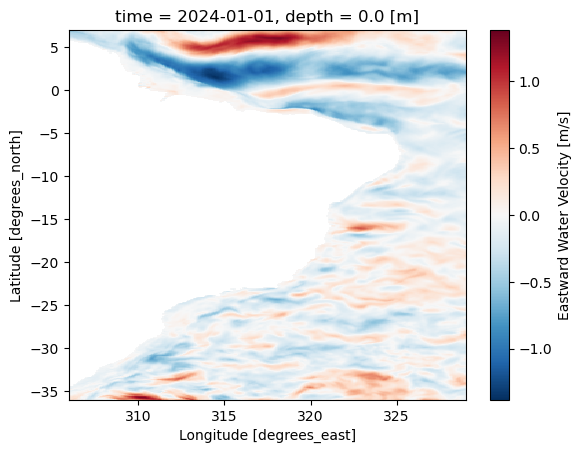

In [9]:
da3[0].plot()

In [10]:
number_of_days = [10, 100, 250, 500, 1000, 1500]

In [11]:
req_time_load = []

for i in range(len(number_of_days)):
    ds_load = da.sel(depth=0).isel(time=np.arange(0, number_of_days[i]))

    try:
        st_time_load = time.time()
        ds2_load = ds_load.load()
        ex_time_load = time.time()
        req_time_load.append(ex_time_load - st_time_load)
    except:
        print(f"Not able to compute {number_of_days[i]} days, an error occurred")
        req_time_load.append(np.nan)

    del ds_load, ds2_load

In [12]:
req_time_lbs = []

for i in range(len(number_of_days)):
    ds_lbs = da.sel(depth=0).isel(time=np.arange(0, number_of_days[i]))
    if number_of_days[i] <= 10:
        stps = int(number_of_days[i])
    else:
        stps = int(number_of_days[i] / 10)

    st_time_lbs = time.time()
    ds2_lbs = ds_lbs.lbs.load_by_step(time=stps)
    ex_time_lbs = time.time()

    req_time_lbs.append(ex_time_lbs - st_time_lbs)

    del ds_lbs, ds2_lbs

Donwloading '6.2MB' of 'water_u' between time=[2018-12-04T12:00:00.000000000, 2018-12-05T15:00:00.000000000]: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
Donwloading '6.2MB' of 'water_u' between time=[2018-12-15T18:00:00.000000000, 2018-12-16T21:00:00.000000000]: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]
Donwloading '15.5MB' of 'water_u' between time=[2019-01-01T15:00:00.000000000, 2019-01-04T15:00:00.000000000]: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]
Donwloading '31.0MB' of 'water_u' between time=[2019-01-29T21:00:00.000000000, 2019-02-05T00:00:00.000000000]: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it]
Donwloading '62.0MB' of 'water_u' between time=[2019-03-27T03:00:00.000000000, 2019-04-08T12:00:00.000000000]: 100%|██████████| 10/10 [03:44<00:00, 22.46s/it]
Donwloading '93.0MB' of 'water_u' between time=[2019-05-22T15:00:00.000000000, 2019-06-10T06:00:00.000000000]: 100%|██████████| 10/10 [01:36<00:00,  9.66s/it]


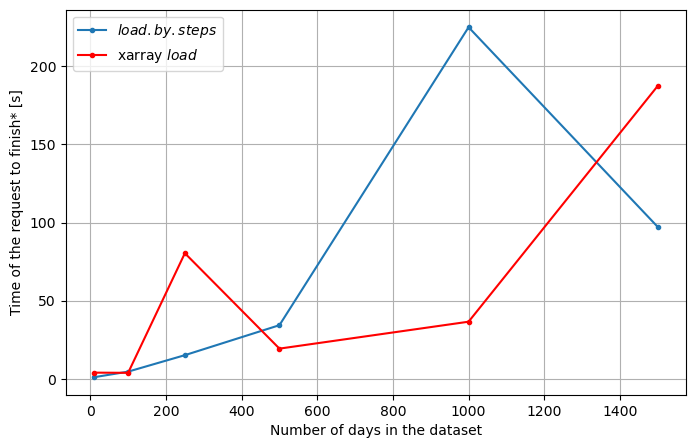

In [13]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(1, 1, 1)
ax.plot(number_of_days, req_time_lbs, marker=".", label="$load.by.steps$")
ax.plot(number_of_days, req_time_load, marker=".", color="r", label="xarray $load$")
ax.set_xlabel("Number of days in the dataset")
ax.set_ylabel("Time of the request to finish* [s]")
ax.grid()
ax.legend(loc="upper left")
# f.savefig('intercomparison.png',facecolor='w',bbox_inches='tight')

## **Example 2**: **_load_by_step_()** by splitting Spatio-Temporal maps in latitude x longitude mini-maps

Another option is to split an spatio-temporal dataset into subdomais with pre-specified sizes in latitude x longitude dimensions, load each of then iteratively, and retrieve the whole dataset at the end of the operation.

In [14]:
def get_steps(dim_size):
    order10 = np.floor(np.log10(dim_size))
    steps = 10 ** (order10 - 1)
    return int(steps)


latsteps = get_steps(da.lat.size)
lonsteps = get_steps(da.lon.size)

In [15]:
da4 = da2.lbs.load_by_step(lat=latsteps, lon=lonsteps)

Donwloading '97.3KB' of 'water_u' between lat=[4.0, 7.0], lon=[328.4000244140625, 328.9599609375]: 100%|██████████| 319/319 [00:55<00:00,  5.76it/s]                      


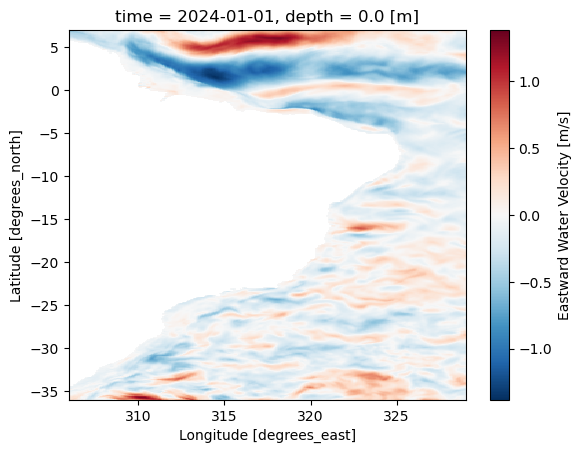

In [16]:
da4[0].plot()

In [19]:
req_time_lbs_ll = []

for i in range(len(number_of_days)):
    ds_lbs = da.sel(depth=0).isel(time=np.arange(0, number_of_days[i]))

    st_time_lbs_ll = time.time()
    ds2_lbs = ds_lbs.lbs.load_by_step(lat=latsteps)
    ex_time_lbs_ll = time.time()

    req_time_lbs_ll.append(ex_time_lbs_ll - st_time_lbs_ll)

    del ds_lbs, ds2_lbs

Donwloading '437.8KB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it]                 
Donwloading '4.4MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]                 
Donwloading '10.9MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]                 
Donwloading '21.9MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]                 
Donwloading '43.8MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:44<00:00,  4.02s/it]                 
Donwloading '65.7MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [01:49<00:00,  9.95s/it]                 


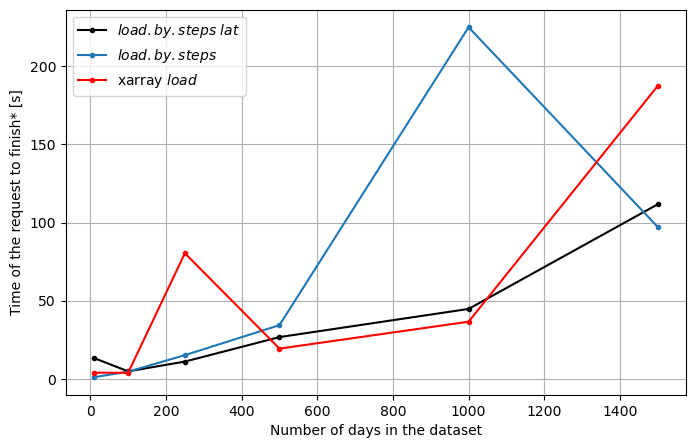

In [29]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(1, 1, 1)
ax.plot(
    number_of_days,
    req_time_lbs_ll,
    color="k",
    marker=".",
    label="$load.by.steps$ $lat$",
)
ax.plot(number_of_days, req_time_lbs, marker=".", label="$load.by.steps$")
ax.plot(number_of_days, req_time_load, marker=".", color="r", label="xarray $load$")
ax.set_xlabel("Number of days in the dataset")
ax.set_ylabel("Time of the request to finish* [s]")
ax.grid()
ax.legend(loc="upper left")
f.savefig("intercomparison_wlat.png", facecolor="w", bbox_inches="tight")

**Note:** It is important to say that sometimes subsetting too much the dataset into smallers chunks can compromise the speed of the job, since there will be a lot of threads delivered. The number of steps to be used are defined by the user but it is important to keep a balance between the number of requests and the size of the data.